In [9]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50  # type: ignore
from tensorflow.keras.models import Sequential  # type: ignore
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization  # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # type: ignore
from tensorflow.keras.optimizers import Adam  # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # type: ignore

In [10]:
# Load the ResNet50 model, pre-trained on ImageNet, excluding the top (classification) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

In [11]:
# Freeze the pre-trained layers so they don't get updated during the first training phase
base_model.trainable = False

In [12]:
# Build the model
model = Sequential([
    base_model,  # Add the pre-trained ResNet base model
    Flatten(),  # Flatten the output of the ResNet
    Dense(1024, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Add dropout to reduce overfitting
    BatchNormalization(),
    Dense(512, activation='relu'),  # Fully connected layer
    Dropout(0.5),
    BatchNormalization(),
    Dense(5, activation='softmax')  # Output layer for 5 classes
])

In [13]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [14]:
# Data augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=30,
                                   brightness_range=[0.8, 1.2],
                                   width_shift_range=0.2,
                                   height_shift_range=0.2)

In [15]:
# No augmentation for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
# Load data
training_set = train_datagen.flow_from_directory(
    r'C:\\Con!\\Terrain-Recognition\\Residua_learning\\Training Data',
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical')

test_set = test_datagen.flow_from_directory(
    r'C:\\Con!\\Terrain-Recognition\\Residua_learning\\Testing Data',
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical')

Found 10000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
# Print number of samples in training and test sets for verification
print(f"Training set samples: {training_set.samples}")
print(f"Test set samples: {test_set.samples}")

Training set samples: 10000
Test set samples: 500


In [19]:
# Calculate steps_per_epoch and validation_steps based on dataset size
train_steps = training_set.samples // training_set.batch_size
val_steps = test_set.samples // test_set.batch_size

In [20]:

# Define callbacks for learning rate adjustment and early stopping
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [21]:
# Train the model
history = model.fit(
    training_set,
    steps_per_epoch=train_steps,
    epochs=20,
    validation_data=test_set,
    validation_steps=val_steps,
    callbacks=[lr_reduction, early_stopping]
)

Epoch 1/20


C:\Users\billa\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


156/156 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.2323 - loss: 2.0842 - val_accuracy: 0.2545 - val_loss: 1.5515 - learning_rate: 0.0010
Epoch 2/20
  1/156 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.2812 - loss: 1.8910

c:\Program Files\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2812 - loss: 1.8910 - val_accuracy: 0.2500 - val_loss: 1.5945 - learning_rate: 0.0010
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 56s 355ms/step - accuracy: 0.2692 - loss: 1.7471 - val_accuracy: 0.1987 - val_loss: 2.2566 - learning_rate: 0.0010
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2031 - loss: 1.6232 - val_accuracy: 0.2115 - val_loss: 2.1762 - learning_rate: 0.0010
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 56s 355ms/step - accuracy: 0.3027 - loss: 1.6139 - val_accuracy: 0.2031 - val_loss: 1.7866 - learning_rate: 5.0000e-04
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3906 - loss: 1.5624 - val_accuracy: 0.2115 - val_loss: 1.6839 - learning_rate: 5.0000e-04


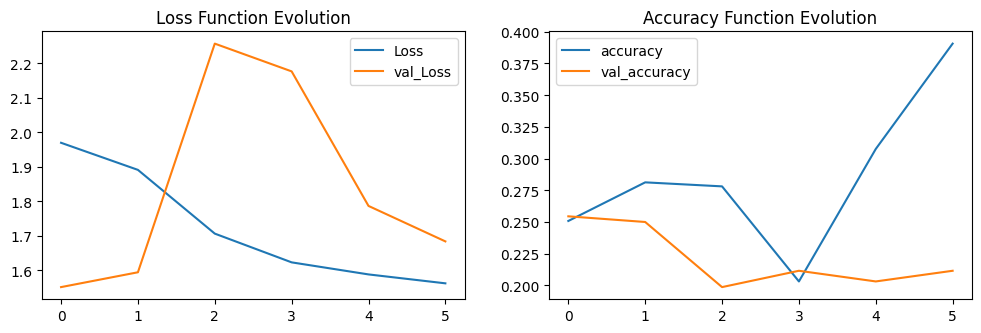

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()


In [26]:

# Save the model
model.save('resnet50_terrain_model.keras')
